## Beyond Linearity 1

We need to add some additional packages to make this work.

So start with *pip3 install ISLP*.  ISLP is 'Introduction to Statistical Learning with Python'.

Then *pip3 install pygam*

In [12]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import matplotlib.pyplot as plt

from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [13]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

We are going to start with some data on wages.  

In [14]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


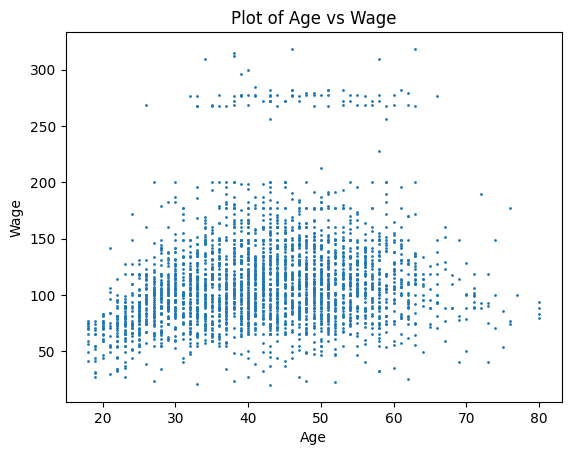

In [15]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')
plt.show()

So that scatterplot suggests that we have a non-linear relationship here.

So let's build some non-linear models

### Polynomial Regression

In [16]:
# This builds the fourth degree polynomial predictors for age
# so that we have in poly_age: age, age^2, age^3, age^4
poly_age = MS([poly('age', degree=4)]).fit(Wage)
# Use the polynomials of age to fit a regression model an 
# ordinary least squares (OLS) one 
M = sm.OLS(y, poly_age.transform(Wage)).fit()
# get the summary for this model
summarize(M)


,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In the output above, we have the y-intercept (111.7), then the coefficient for age (447.1), the coefficient for age^2 (-478.3),
    the coefficient for age^3 (125.5) and the coefficient for age^4 (-77.9).

In [ ]:
For making prei

In [18]:
#make a set of 100 values from the smallest age to the largest age
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
# put those values into a dataframe called age_df
age_df = pd.DataFrame({'age': age_grid})
# make the values at which we are going to predict and transform them 
Xnew = poly_age.transform(age_df)
# 
preds = M.get_prediction(Xnew)

#print(preds.summary_frame())
age_df['preds']=preds.predicted_mean


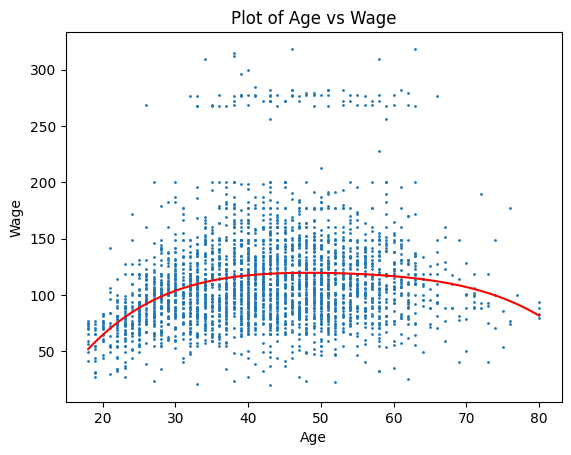

In [19]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add regression line to plot
plt.plot(age_df['age'],age_df['preds'] , color='red')

plt.show()

The above plot as the fourth order model for prediction of an individuals wage by age.

Note that the model is not quadratic as it has an extended area of peak which is not 
the form that a quadratic would take.

### Splines

The idea of a spliced lines, or splines, is to fit a functional curve, by default cubic, to data in a window, then
fit another  curve to the next window, etc through all the windows, and have the lines be spliced together.
Where the windows come together are called knots because they 'tie together' one curve to the next.

We do this by creating bases, see Linear Algebra, as predictors which are effectively perpendicular to each other.

The `BSpline()`  function generates the
entire matrix of basis functions for splines with the specified set of
knots. By default, the B-splines produced are cubic. To change the degree, use
the argument `degree`.

In [20]:
# BSplines are basis splines (bs)
# basically these are orthogonal, read perpendicular, predictors that ensure there 
# is not much multicollinearity between them
# the knots are the locations on the x axis
bs_1 = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
# transform the splines to fit the age and the function below
bs_age = bs_1.transform(age)
# get the number of rows and columns for bs_age
bs_age.shape

(3000, 7)

In [27]:
bs_age = MS([bs('age', degree=3,internal_knots=[25,40,60])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs = bs_age.fit_transform(Wage)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M2
M2 = sm.OLS(y, Xbs).fit()
# get the coefficient summary for M2
summarize(M2)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, degree=3, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, degree=3, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is because, by default,
`bs()` assumes `intercept=False`, since we typically have an overall intercept in the model.
So it generates the spline basis with the given knots,  and then discards one of the basis functions to account for the intercept. 

We could also use the `df` (degrees of freedom) option to
specify the complexity of the spline.  We see above that with 3 knots,
the spline basis has 6 columns or degrees of freedom.  When we specify
`df=6` rather than the actual knots, `bs()` will produce a
spline with 3 knots chosen at uniform quantiles of the training data.
We can see these chosen knots most easily using `Bspline()` directly:

In [24]:
BSpline(df=6).fit(age).internal_knots_


array([33.75, 42.  , 51.  ])

In [28]:
Xnew = bs_age.transform(age_df)

preds2 = M2.get_prediction(Xnew)

#print(preds.summary_frame())
age_df['preds2']=preds2.predicted_mean

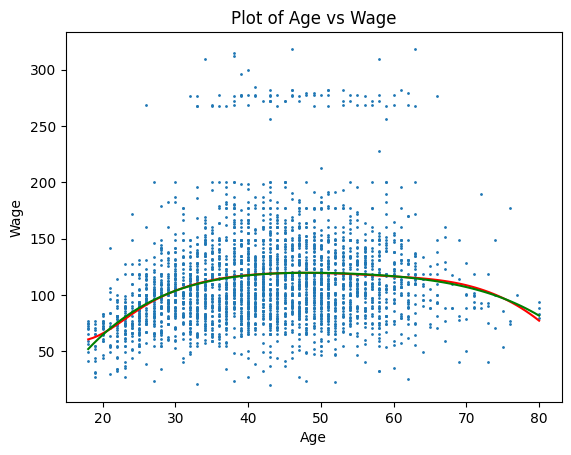

In [ ]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='green')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")

plt.show()

The predictions are similar but with some slight differences between the polynomial and the spline fit.
If we were to change the polynomial order or the type of spline we would get different predictions.



Below we will change the type of spline to be linear (degree=1) and refit the model. 

In [37]:
bs_age2 = MS([bs('age', degree=1,internal_knots=[25,40,60])])
# MS is a function that takes python sequences and makes them into a matrix
Xbs2 = bs_age2.fit_transform(Wage)
# The fit_transform() method in Python, particularly within the scikit-learn library, 
# serves as a combined operation of fitting and transforming data. 
# It is commonly used in data preprocessing steps for machine learning. 
# The fit() part calculates necessary parameters from the data, 
# such as mean and standard deviation in the case of scaling. 
# The transform() part then applies these calculated parameters to transform the data. 
# Using fit_transform() performs both actions sequentially in a single step, 
# which can be more efficient than calling fit() and transform() separately.

# fit a regression model to these data with y as the response and Xbs as our predictors
# call that model M2
M3 = sm.OLS(y, Xbs2).fit()
# get the coefficient summary for M2
summarize(M3)

,coef,std err,t,P>|t|
intercept,54.3328,5.957,9.120,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[0]",37.6451,6.817,5.522,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[1]",65.8474,6.019,10.940,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[2]",63.8504,6.319,10.104,0.000
"bs(age, degree=1, internal_knots=[25, 40, 60])[3]",33.7715,10.580,3.192,0.001


In [38]:
Xnew = bs_age2.transform(age_df)

preds3 = M3.get_prediction(Xnew)

#print(preds.summary_frame())
age_df['preds3']=preds3.predicted_mean

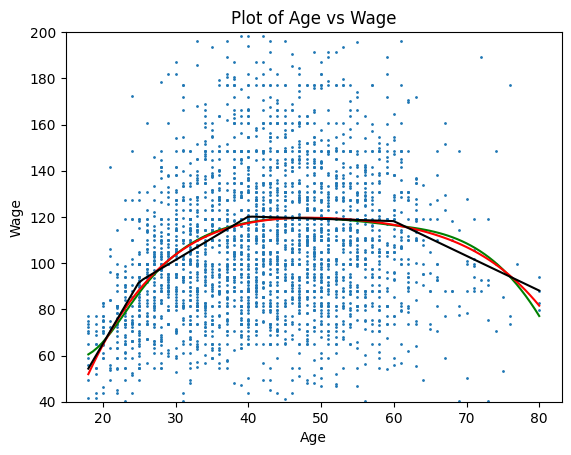

In [ ]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='green')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")
# Add prediction line for degree =2 spline
plt.plot(age_df['age'],age_df['preds3'],color="black")

plt.show()

Let's change the y-axis so that we can more closely see that is going on.  

We'll do that below with the *plt.ylim* command.

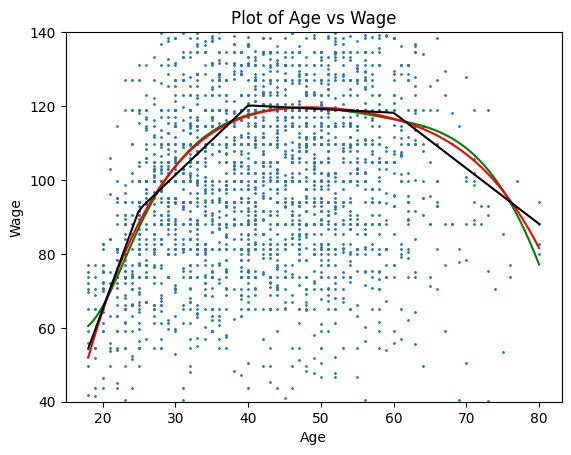

In [41]:
plt.scatter( Wage['age'],Wage['wage'],s=1)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Wage' )
plt.title('Plot of Age vs Wage')


# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds2'] , color='green')
# Add prediction line to plot
plt.plot(age_df['age'],age_df['preds'],color="red")
# Add prediction line for degree =2 spline
plt.plot(age_df['age'],age_df['preds3'],color="black")

plt.ylim([40,140])
plt.show()

We specified knots at Age = 25,Age = 40, and Age =60.  From the black curve, which has a linear fit 
in each window we can clearly see the 'elbows' at those age values where the predicted curve 
changes slope while still being 'smooth' (or even continuous in a mathematical sense).



Tasks

    1. Read in National Football League historical draft data located at http://myslu.stlawu.edu/~msch/data/NFLDraft.csv
    
    2. G is the number of games played by a player in their career. Pick is the position at which they were selected in the National Football League (NFL) draft. Plot G vs Pick.

    3. With G as the response and Pick as the predictor, fit a 4th degree polynomial, and a basis spline with 
    four knots at 30, 60, 90 and 120 that is degree 3, and another basis spline with the same knots that 
    is degree 1.

    4. Plot the predicted functions for your models above.
    
